In [25]:
! pip install -qU langgraph langgraph-checkpoint-postgres psycopg psycopg[binary] psycopg-pool langchain_google_genai


^C


In [26]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,MessagesState,END,START
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
import os

load_dotenv()

db_url = os.getenv('DB_URL')
google_api = os.getenv('GEMINI_API_KEY')

llm:ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=google_api)


In [27]:
from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver

# Connection pool for efficient database access
connection_kwargs = {"autocommit": True, "prepare_threshold": 0}


# Create a persistent connection pool
pool = ConnectionPool(conninfo=db_url, max_size=20, kwargs=connection_kwargs)

# Initialize PostgresSaver checkpointer
checkpoint = PostgresSaver(pool)
checkpoint.setup()  # Ensure database tables are set up

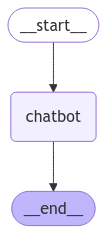

In [28]:

class State(MessagesState):
    pass

def chatbot(state:State):
    return {'messages':llm.invoke(state['messages'])}

workflow : StateGraph = StateGraph(State)

workflow.add_node('chatbot',chatbot)

workflow.add_edge(START,'chatbot')
workflow.add_edge('chatbot',END)

graph:CompiledStateGraph = workflow.compile(checkpointer=checkpoint)

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
# Configuration for thread
config = {"configurable": {"thread_id": "1"}}

# Start a conversation
input_message = HumanMessage(content="Can you describe about abstract paintings? in 1 line")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

graph_state = graph.get_state(config)
graph_state


================================== Ai Message ==================================

Abstract paintings use color, shape, and composition to express ideas and emotions without depicting recognizable objects.


StateSnapshot(values={'messages': [HumanMessage(content='Can you describe about abstract paintings?', additional_kwargs={}, response_metadata={}, id='f692dfd0-ee1c-4546-a343-24c2059b7486'), AIMessage(content='Abstract paintings are works of art that don\'t depict recognizable objects or scenes from the real world.  Instead, they focus on expressing ideas, emotions, or formal elements like color, line, shape, form, and texture.  They move beyond representation and explore the visual language of art itself.\n\nHere\'s a breakdown of key aspects:\n\n* **Emphasis on Form and Composition:**  The arrangement of elements within the painting—the interplay of colors, shapes, lines, and textures—is paramount.  The overall composition becomes the subject matter, rather than a depiction of something external.\n\n* **Non-representational:**  Unlike realistic or impressionistic paintings, abstract art doesn\'t attempt to mimic reality.  It may suggest forms or evoke feelings, but it doesn\'t strive 

In [42]:
pool.close()